Purpose: make a model to predict if a people will fell isolated or not by analyzing one's frequency of hug, kiss, and sex in the last three month.

In [23]:
import pandas as pd
cols = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/var_names.csv")
data = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv",
                   na_values=["9999", "", " ", "Presented but no response", "NA"])
empty = (data.isna().sum()==data.shape[0])
data = data[empty.index[~empty]] # keep non empty columns only
dataV2 = data[data.REMOVE_case=='No'].copy()
dataV2_cohort = dataV2[dataV2.SURVEY_cohort_participant].copy()
dataV2_cohortV2 = dataV2_cohort[dataV2_cohort.SURVEY_collection_year!=2023].copy()
missingness_limit = 100 # this retains 166 of 1024 columns that aren't fully empty
columns2keep = dataV2_cohortV2.isna().sum() < missingness_limit
columns2keep = columns2keep.index[columns2keep]
dataV2_cohortV3 = dataV2_cohortV2[columns2keep].copy()
pd.set_option('display.max_columns', dataV2_cohortV3.shape[1]) # Can cause jupyter notebooks to crash
# DO NOT USE in conjuection with pd.set_option('display.max_rows', 1000) 
dataV2_cohortV3


/tmp/ipykernel_90/2218674287.py:3: DtypeWarning: Columns (129,408,630,671,689,978,1001,1002,1006,1007,1008,1080,1113,1115,1116,1117,1118,1119,1120,1121,1124,1125,1126,1127,1128,1213,1214,1215,1216,1217,1218,1263,1266,1342,1343,1344,1345,1346,1347,1348,1349,1390,1391,1393,1439,1442,1463,1546,1549,1552,1555,1558,1561) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv",


,UNIQUE_id,UNIQUE_num_records,ELIGIBLE_consent,COVID_prevention_distancing,COVID_prevention_masks,COVID_prevention_hand_washing,COVID_prevention_reduce_people,COVID_prevention_avoid_trips,COVID_prevention_household,COVID_vaccinated,WELLNESS_life_satisfaction,WELLNESS_malach_pines_burnout_measure_tired,WELLNESS_malach_pines_burnout_measure_disappointed,WELLNESS_malach_pines_burnout_measure_hopeless,WELLNESS_malach_pines_burnout_measure_trapped,WELLNESS_malach_pines_burnout_measure_helpless,WELLNESS_malach_pines_burnout_measure_depressed,WELLNESS_malach_pines_burnout_measure_sick,WELLNESS_malach_pines_burnout_measure_worthless,WELLNESS_malach_pines_burnout_measure_difficulty_sleeping,WELLNESS_malach_pines_burnout_measure_had_it,CONNECTION_activities_talked_day_p3m,CONNECTION_activities_talked_family_p3m,CONNECTION_activities_talked_job_p3m,CONNECTION_activities_talked_hobbies_p3m,CONNECTION_activities_phone_p3m,CONNECTION_activities_letter_or_email_p3m,CONNECTION_activities_checked_in_p3m,CONNECTION_activities_text_or_messaged_p3m,CONNECTION_activities_chat_p3m,CONNECTION_activities_video_chat_p3m,CONNECTION_activities_group_video_chat_p3m,CONNECTION_activities_walk_p3m,CONNECTION_activities_coffee_p3m,CONNECTION_activities_board_games_p3m,CONNECTION_activities_computer_games_p3m,CONNECTION_activities_onlinegames_p3m,CONNECTION_activities_visited_friends_p3m,CONNECTION_activities_visited_family_p3m,CONNECTION_activities_community_p3m,CONNECTION_activities_helped_p3m,CONNECTION_activities_meeting_work_p3m,CONNECTION_activities_discussion_group_p3m,CONNECTION_activities_group_exercise_p3m,CONNECTION_activities_church_p3m,CONNECTION_activities_new_friend_p3m,CONNECTION_activities_hug_p3m,CONNECTION_activities_kissed_p3m,CONNECTION_activities_sex_p3m,LONELY_ucla_loneliness_scale_companionship,LONELY_ucla_loneliness_scale_left_out,LONELY_ucla_loneliness_scale_isolated,CONNECTION_social_num_close_friends_grouped,CONNECTION_social_days_family_p7d_grouped,CONNECTION_social_days_friends_p7d_grouped,CONNECTION_social_days_coworkers_and_classmates_p7d_grouped,CONNECTION_social_days_neighbours_p7d_grouped,CONNECTION_social_time_family_p7d_grouped,CONNECTION_social_time_friends_p7d_grouped,CONNECTION_social_time_coworkers_and_classmates_p7d_grouped,CONNECTION_social_time_neighbours_p7d_grouped,CONNECTION_social_num_family_p7d_grouped,CONNECTION_social_num_friends_p7d_grouped,CONNECTION_social_num_coworkers_and_classmates_p7d_grouped,CONNECTION_social_num_neighbours_p7d_grouped,CONNECTION_preference_time_family_grouped,CONNECTION_preference_time_friends_grouped,CONNECTION_preference_time_coworkers_classmates_grouped,CONNECTION_preference_time_neighbours_grouped,LONELY_dejong_emotional_social_loneliness_scale_emptiness,LONELY_dejong_emotional_social_loneliness_scale_rely,LONELY_dejong_emotional_social_loneliness_scale_trust,LONELY_dejong_emotional_social_loneliness_scale_close,LONELY_dejong_emotional_social_loneliness_scale_miss,LONELY_dejong_emotional_social_loneliness_scale_rejected,LONELY_direct,LONELY_change_pre_covid,LONELY_others_aware,PSYCH_zimet_multidimensional_social_support_scale_need,PSYCH_zimet_multidimensional_social_support_scale_joys,PSYCH_zimet_multidimensional_social_support_scale_positive_not_scored,PSYCH_zimet_multidimensional_social_support_scale_gets_me_not_scored,PSYCH_zimet_multidimensional_social_support_scale_family_helps,PSYCH_zimet_multidimensional_social_support_scale_family_emotional,PSYCH_zimet_multidimensional_social_support_scale_comfort,PSYCH_zimet_multidimensional_social_support_scale_help,PSYCH_zimet_multidimensional_social_support_scale_go_wrong,PSYCH_zimet_multidimensional_social_support_scale_problems_family,PSYCH_zimet_multidimensional_social_support_scale_problems_friends,PSYCH_zimet_multidimensional_social_support_scale_sorrows,PSYCH_zimet_multidimensional_social_support_scale_feelings,PSYCH_zimet_multidimensional_social_support_scale_decisions,WELLNESS_self_rated_physical_health,WELLNESS_self_rated_me

In [24]:
dataV2_cohortV3[['CONNECTION_activities_hug_p3m','CONNECTION_activities_kissed_p3m','CONNECTION_activities_sex_p3m','LONELY_ucla_loneliness_scale_isolated']]

,CONNECTION_activities_hug_p3m,CONNECTION_activities_kissed_p3m,CONNECTION_activities_sex_p3m,LONELY_ucla_loneliness_scale_isolated
19,Daily or almost daily,Daily or almost daily,A few times a month,Often
21,Daily or almost daily,Daily or almost daily,A few times a month,Some of the time
71,A few times a week,A few times a week,Not in the past three months,Some of the time
77,A few times a month,Daily or almost daily,Monthly,Some of the time
78,Daily or almost daily,Daily or almost daily,Monthly,Some of the time
...,...,...,...,...
11379,Not in the past three months,Not in the past three months,Not in the past three months,Often
11380,A few times a month,Not in the past three months,Not in the past three months,Some of the time
11412,Daily or almost daily,Daily or almost daily,Weekly,Some of the time
11428,A few times a month,Not in the past three months,Not in the past three months,Some of the time


In [25]:
dataV2_cohortV3 = dataV2_cohortV3.rename(columns={
    'CONNECTION_activities_hug_p3m': 'hug',
    'CONNECTION_activities_kissed_p3m': 'kiss',
    'CONNECTION_activities_sex_p3m': 'sex',
    'LONELY_ucla_loneliness_scale_isolated': 'loneliness'
})

In [26]:
# train and test data 
from sklearn.model_selection import train_test_split

# Target variable y and feature matrix X
y = (dataV2_cohortV3['loneliness'] == 'Often').astype(int) 
# Target variable y - binarize the column into 1 for "Often" and 0 for others
X = dataV2_cohortV3[['hug','kiss','sex']]

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine X_train, y_train, X_test, and y_test into the final training and testing sets
dataV2_cohortV3_train = pd.concat([X_train, y_train], axis=1)
dataV2_cohortV3_test = pd.concat([X_test, y_test], axis=1)

# Report the number of observations in the training and test datasets
train_size = dataV2_cohortV3_train.shape[0]
test_size = dataV2_cohortV3_test.shape[0]
train_size, test_size

(680, 170)

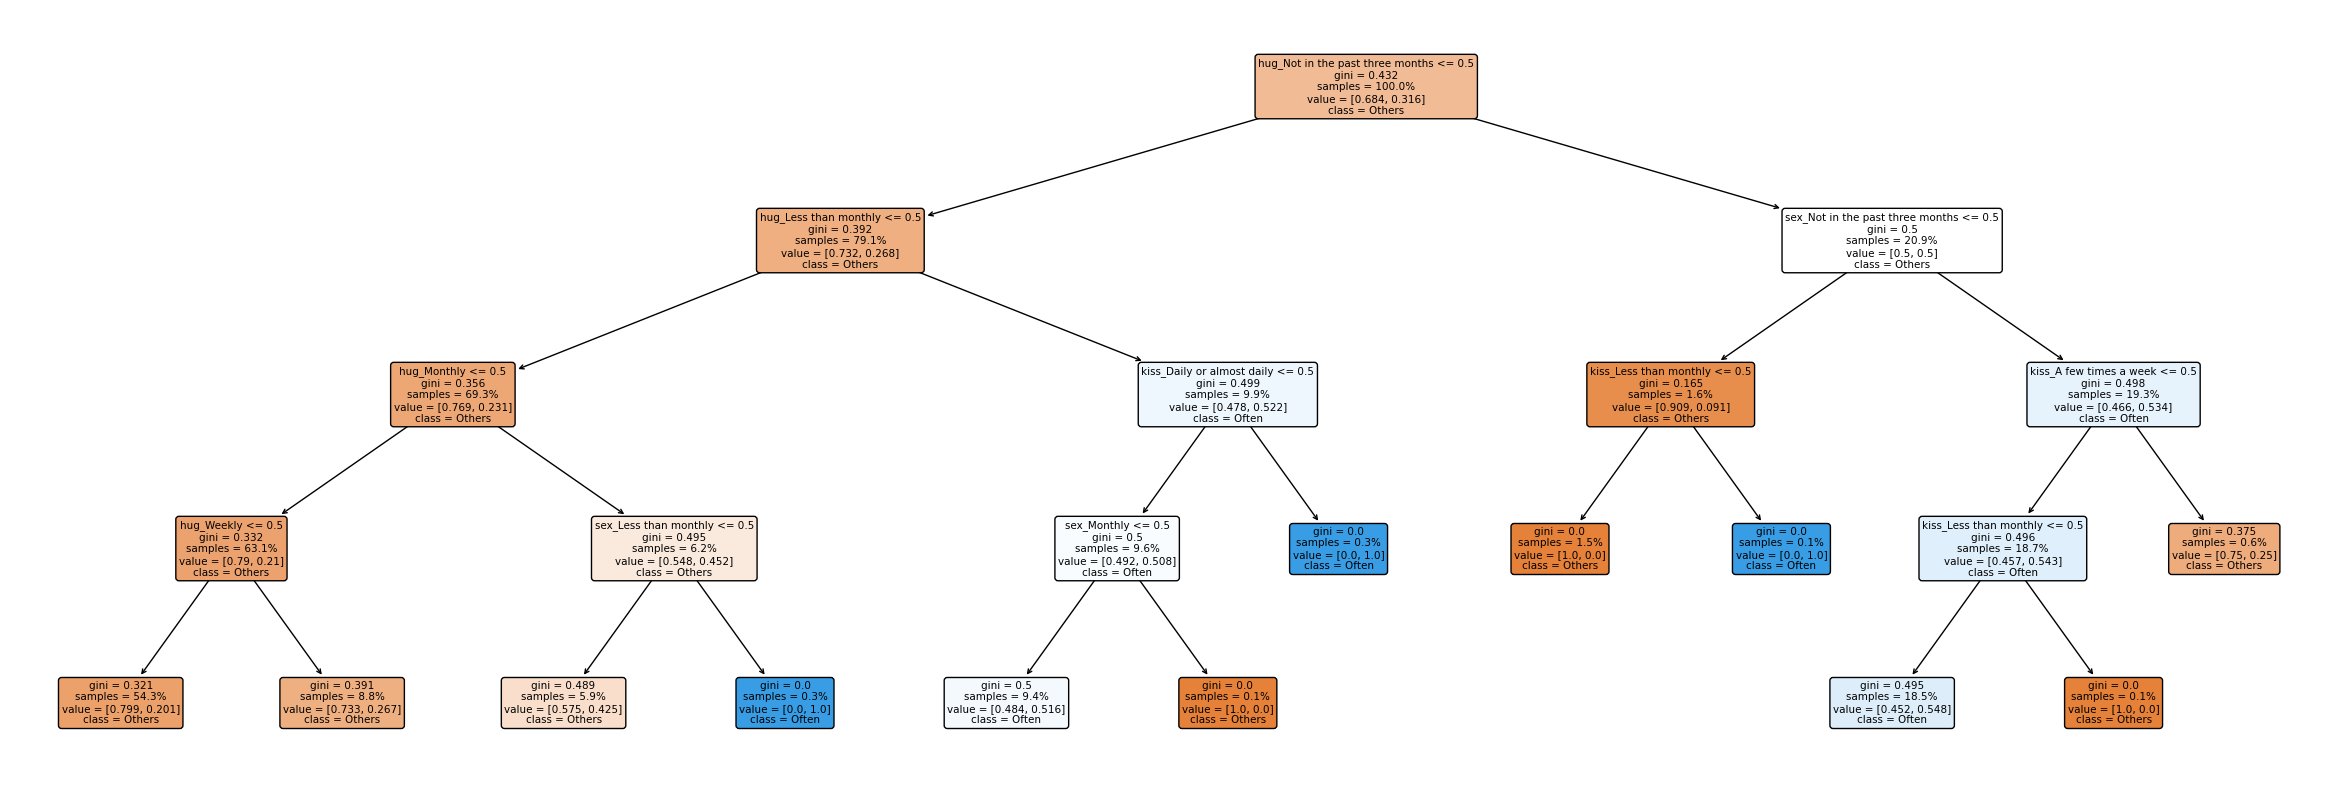

In [27]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

# Encode non-numeric features using pandas.get_dummies
# I mean: binarize the independent vatiables.
X_encoded = pd.get_dummies(X, drop_first=True)

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=4, random_state=42)

# Train the classifier
clf.fit(X_encoded.loc[X_train.index], y_train)

# Plot the decision tree
plt.figure(figsize=(30, 10))
tree.plot_tree(
    clf,
    filled=True,
    feature_names=X_encoded.columns,  # Use the encoded column names
    class_names=['Others', 'Often'],  # Adjust class names to match target encoding
    rounded=True,
    proportion=True
)
plt.show('renerder = png')

# To read this decision tree after encoding the indenpendent variables: If a split involves a dummy variable like hug_p3m_Not in the past three months, it means:
#value = 1: The participant did not engage in hugging in the past three months.
#value = 0: The participant engaged in hugging in the past three months.



Example to read: hug_p3m_Not in the past three months ≤ 0.5
If True (value ≤ 0.5, i.e., hugging did happen in the past three months):

Follow the left branch.
This subset of data is further split or classified based on the next feature.
If False (value > 0.5, i.e., hugging did not happen in the past three months):

Follow the right branch.
This subset is classified or split based on another feature.

In [28]:
# Test
X_test_encoded = pd.get_dummies(X_test, drop_first=True) # encode the data at first
y_pred_clf = clf.predict(X_test_encoded) 

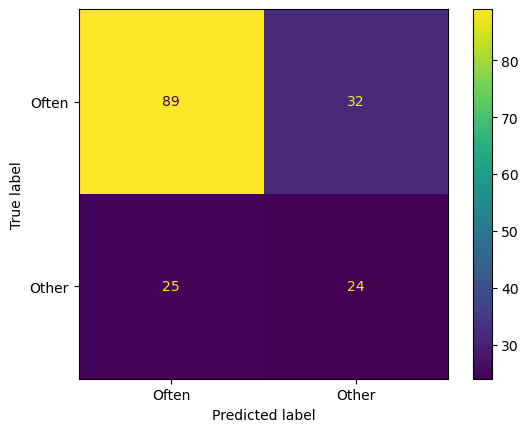

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix for clf
cm_clf = confusion_matrix(y_test, y_pred_clf, labels=[False, True])

# Create and plot confusion matrix for clf
cm_disp_clf = ConfusionMatrixDisplay(confusion_matrix=cm_clf, display_labels=['Often', 'Other'])
_ = cm_disp_clf.plot()

In [30]:
# Extract TP, TN, FP, FN from the confusion matrix
tn, fp, fn, tp = cm_clf.ravel()

# Calculate metrics
sensitivity = tp / (tp + fn)  # Recall for "Often" (positive class)
specificity = tn / (tn + fp)  # Recall for "Other" (negative class)
accuracy = (tp + tn) / (tp + tn + fp + fn)
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0


print(f"False Negative Rate (FNR): {fnr:.2f}")
print(f"Sensitivity (Recall for 'Often'): {sensitivity:.2f}")
print(f"Specificity (Recall for 'Other'): {specificity:.2f}")
print(f"Accuracy: {accuracy:.2f}")


False Negative Rate (FNR): 0.51
Sensitivity (Recall for 'Often'): 0.49
Specificity (Recall for 'Other'): 0.74
Accuracy: 0.66


My opinion: cuz the false negative rate is high, so maybe this model is not very good, which means we can not predict if a person is isolated by analyzing the frequency of hug, kiss, and sex frequency in the past three months.

Bootstrapping and null hypothesis for hug and loneliness

Bootstrap Analysis for Binarized Hugging and Loneliness:
Observed Mean Difference: -0.2378974447202628
95% Confidence Interval for Mean Difference: [-0.32002117376176115, -0.16077197184938433]
P-value from Bootstrapping: 0.502


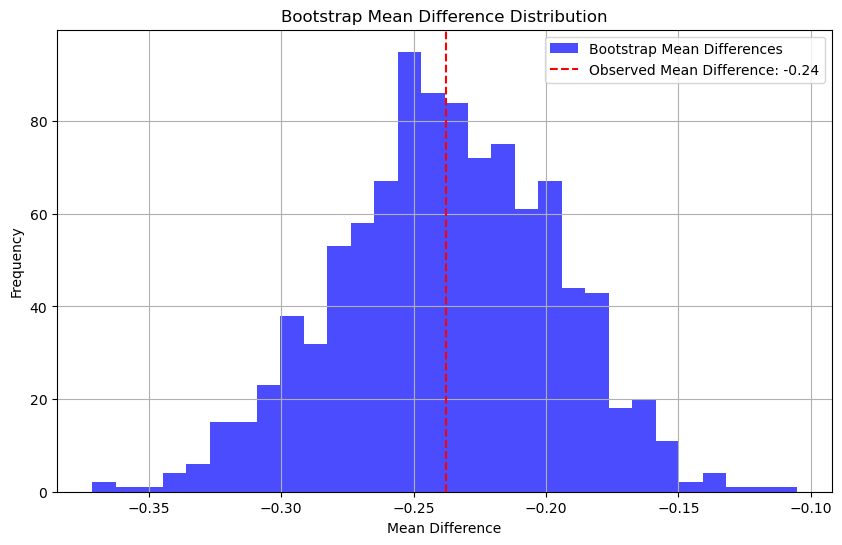

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Binarize 'hug': 0 for 'Not in the past three months', 1 otherwise
dataV2_cohortV3['hug_binary'] = (dataV2_cohortV3['hug'] != 'Not in the past three months').astype(int)

# Binarize 'loneliness': 1 for 'Often', 0 otherwise
dataV2_cohortV3['loneliness_binary'] = (dataV2_cohortV3['loneliness'] == 'Often').astype(int)

# Observed mean difference
observed_mean_diff = (
    dataV2_cohortV3[dataV2_cohortV3['hug_binary'] == 1]['loneliness_binary'].mean()
    - dataV2_cohortV3[dataV2_cohortV3['hug_binary'] == 0]['loneliness_binary'].mean()
)

# Function to perform normal bootstrapping
def bootstrap_mean_diff(data, independent, dependent, n_samples):
    bootstrapped_diffs = []
    for _ in range(n_samples):
        resampled_data = data.sample(frac=1, replace=True)
        mean_hugged = resampled_data[resampled_data[independent] == 1][dependent].mean()
        mean_not_hugged = resampled_data[resampled_data[independent] == 0][dependent].mean()
        bootstrapped_diffs.append(mean_hugged - mean_not_hugged)
    return bootstrapped_diffs

# Perform bootstrapping
n_bootstrap = 1000
bootstrap_diffs = bootstrap_mean_diff(dataV2_cohortV3, 'hug_binary', 'loneliness_binary', n_bootstrap)

# Calculate Confidence Interval
ci_lower = np.percentile(bootstrap_diffs, 2.5)
ci_upper = np.percentile(bootstrap_diffs, 97.5)

# Calculate p-value
p_value_bootstrap = np.mean(np.array(bootstrap_diffs) >= observed_mean_diff)

# Print results
print("Bootstrap Analysis for Binarized Hugging and Loneliness:")
print(f"Observed Mean Difference: {observed_mean_diff}")
print(f"95% Confidence Interval for Mean Difference: [{ci_lower}, {ci_upper}]")
print(f"P-value from Bootstrapping: {p_value_bootstrap}")

# Plot the bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_diffs, bins=30, alpha=0.7, label='Bootstrap Mean Differences', color='blue')
plt.axvline(observed_mean_diff, color='red', linestyle='dashed', linewidth=1.5, label=f'Observed Mean Difference: {observed_mean_diff:.2f}')
plt.title("Bootstrap Mean Difference Distribution")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show('renerder = png')


Fail to reject the null hypothesis.

Null hypothesis: There is no difference in the mean loneliness frequency between individuals who hugged recently and those who did not.

Bootstrap Analysis for Binarized kissing and Loneliness:
Observed Mean Difference: -0.1840136054421769
95% Confidence Interval for Mean Difference: [-0.24643091024651523, -0.1193223643141757]
P-value from Bootstrapping: 0.497


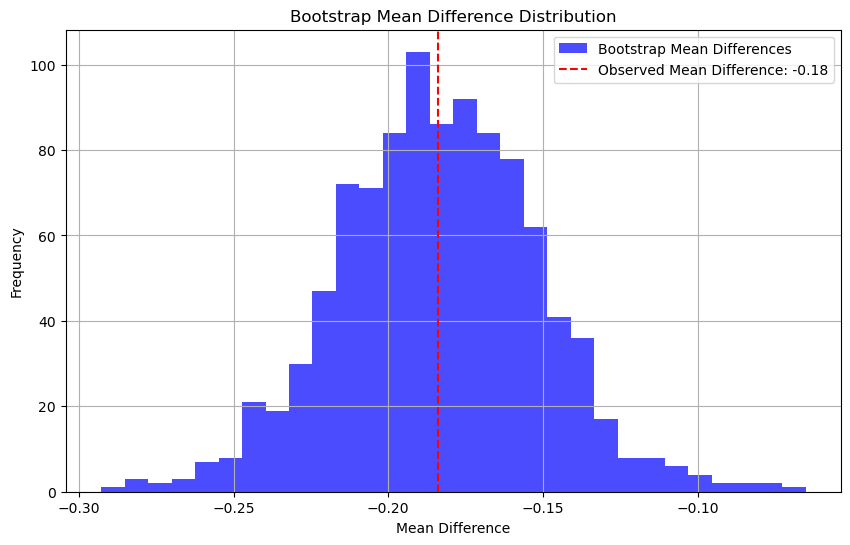

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Binarize 'kiss': 0 for 'Not in the past three months', 1 otherwise
dataV2_cohortV3['kiss_binary'] = (dataV2_cohortV3['kiss'] != 'Not in the past three months').astype(int)

# Binarize 'loneliness': 1 for 'Often', 0 otherwise
dataV2_cohortV3['loneliness_binary'] = (dataV2_cohortV3['loneliness'] == 'Often').astype(int)

# Observed mean difference
observed_mean_diff = (
    dataV2_cohortV3[dataV2_cohortV3['kiss_binary'] == 1]['loneliness_binary'].mean()
    - dataV2_cohortV3[dataV2_cohortV3['kiss_binary'] == 0]['loneliness_binary'].mean()
)

# Function to perform normal bootstrapping
def bootstrap_mean_diff(data, independent, dependent, n_samples):
    bootstrapped_diffs = []
    for _ in range(n_samples):
        resampled_data = data.sample(frac=1, replace=True)
        mean_hugged = resampled_data[resampled_data[independent] == 1][dependent].mean()
        mean_not_hugged = resampled_data[resampled_data[independent] == 0][dependent].mean()
        bootstrapped_diffs.append(mean_hugged - mean_not_hugged)
    return bootstrapped_diffs

# Perform bootstrapping
n_bootstrap = 1000
bootstrap_diffs = bootstrap_mean_diff(dataV2_cohortV3, 'kiss_binary', 'loneliness_binary', n_bootstrap)

# Calculate Confidence Interval
ci_lower = np.percentile(bootstrap_diffs, 2.5)
ci_upper = np.percentile(bootstrap_diffs, 97.5)

# Calculate p-value
p_value_bootstrap = np.mean(np.array(bootstrap_diffs) >= observed_mean_diff)

# Print results
print("Bootstrap Analysis for Binarized kissing and Loneliness:")
print(f"Observed Mean Difference: {observed_mean_diff}")
print(f"95% Confidence Interval for Mean Difference: [{ci_lower}, {ci_upper}]")
print(f"P-value from Bootstrapping: {p_value_bootstrap}")

# Plot the bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_diffs, bins=30, alpha=0.7, label='Bootstrap Mean Differences', color='blue')
plt.axvline(observed_mean_diff, color='red', linestyle='dashed', linewidth=1.5, label=f'Observed Mean Difference: {observed_mean_diff:.2f}')
plt.title("Bootstrap Mean Difference Distribution")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show('renerder = png')


fail to reject null hypothesis

Null hypothesis: There is no difference in the mean loneliness frequency between individuals who kissed recently and those who did not.

Bootstrap Analysis for Binarized sex and Loneliness:
Observed Mean Difference: -0.16154854228480336
95% Confidence Interval for Mean Difference: [-0.2242001161412394, -0.09720682790277861]
P-value from Bootstrapping: 0.515


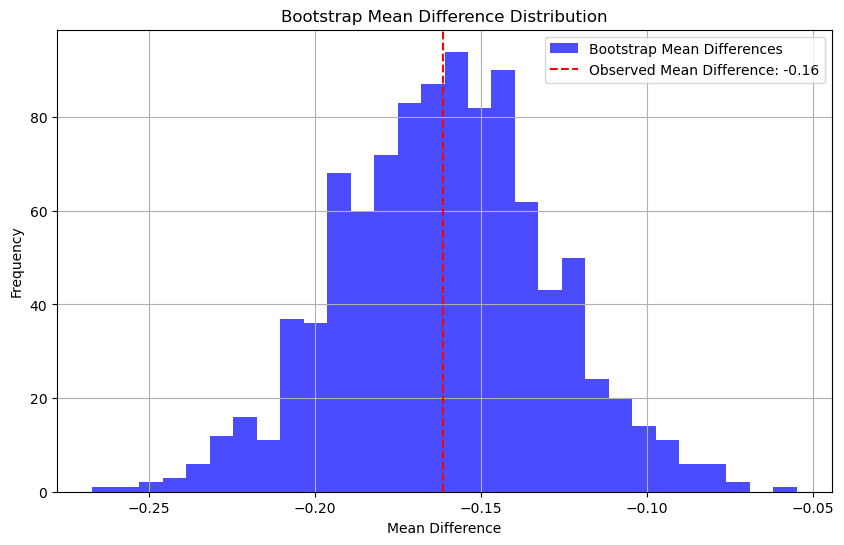

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Binarize 'hug': 0 for 'Not in the past three months', 1 otherwise
dataV2_cohortV3['sex_binary'] = (dataV2_cohortV3['sex'] != 'Not in the past three months').astype(int)

# Binarize 'loneliness': 1 for 'Often', 0 otherwise
dataV2_cohortV3['loneliness_binary'] = (dataV2_cohortV3['loneliness'] == 'Often').astype(int)

# Observed mean difference
observed_mean_diff = (
    dataV2_cohortV3[dataV2_cohortV3['sex_binary'] == 1]['loneliness_binary'].mean()
    - dataV2_cohortV3[dataV2_cohortV3['sex_binary'] == 0]['loneliness_binary'].mean()
)

# Function to perform normal bootstrapping
def bootstrap_mean_diff(data, independent, dependent, n_samples):
    bootstrapped_diffs = []
    for _ in range(n_samples):
        resampled_data = data.sample(frac=1, replace=True)
        mean_hugged = resampled_data[resampled_data[independent] == 1][dependent].mean()
        mean_not_hugged = resampled_data[resampled_data[independent] == 0][dependent].mean()
        bootstrapped_diffs.append(mean_hugged - mean_not_hugged)
    return bootstrapped_diffs

# Perform bootstrapping
n_bootstrap = 1000
bootstrap_diffs = bootstrap_mean_diff(dataV2_cohortV3, 'sex_binary', 'loneliness_binary', n_bootstrap)

# Calculate Confidence Interval
ci_lower = np.percentile(bootstrap_diffs, 2.5)
ci_upper = np.percentile(bootstrap_diffs, 97.5)

# Calculate p-value
p_value_bootstrap = np.mean(np.array(bootstrap_diffs) >= observed_mean_diff)

# Print results
print("Bootstrap Analysis for Binarized sex and Loneliness:")
print(f"Observed Mean Difference: {observed_mean_diff}")
print(f"95% Confidence Interval for Mean Difference: [{ci_lower}, {ci_upper}]")
print(f"P-value from Bootstrapping: {p_value_bootstrap}")

# Plot the bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_diffs, bins=30, alpha=0.7, label='Bootstrap Mean Differences', color='blue')
plt.axvline(observed_mean_diff, color='red', linestyle='dashed', linewidth=1.5, label=f'Observed Mean Difference: {observed_mean_diff:.2f}')
plt.title("Bootstrap Mean Difference Distribution")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show('renerder = png')
